In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import tensorflow as tf
import torch.nn as nn
import torch.nn.functional as F
import torch
import tensorboardX

import pickle
import os
import random

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [ ]:
!! unzip data.zip

In [2]:
!! dir data

[' ’®¬ ў гбва®©бвўҐ C Ё¬ҐҐв ¬ҐвЄг Windows',
 ' ‘ҐаЁ©\xadл© \xad®¬Ґа в®¬\xa0: 4C9E-28C1',
 '',
 ' ‘®¤Ґа¦Ё¬®Ґ Ї\xa0ЇЄЁ C:\\Users\\maxkv\\PycharmProjects\\DeepLearningHw\\05\\data',
 '',
 '24.10.2018  18:56    <DIR>          .',
 '24.10.2018  18:56    <DIR>          ..',
 '02.08.2017  18:08               563 acid_properties.csv',
 '03.08.2017  03:24        32я989я053 family_classification_metadata.tab',
 '03.08.2017  03:25       138я993я226 family_classification_sequences.tab',
 '02.08.2017  18:08           407я180 nice_embed_tsne.csv',
 '               4 д\xa0©«®ў    172я390я022 Ў\xa0©в',
 '               2 Ї\xa0Ї®Є  406я029я336я576 Ў\xa0©в бў®Ў®¤\xad®']

In [2]:
seq_df = pd.read_table('data\\family_classification_sequences.tab')
seq_df.head()

Sequences
0  MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1  MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2  MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3  MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4  MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...

In [3]:
def make_codones(sseq):
    crop = len(sseq) % 3
    cropped_seq = sseq[:-crop] if crop > 0 else sseq

    return [cropped_seq[i:i+3] for i in range(0, len(cropped_seq), 3)]

def create_all_codones(df):
    for i in range(df.shape[0]):
        row = df.iloc[i, :][0]
        seq = row
        for i in range(3):
            yield make_codones(seq[i:])    

In [4]:
all_codones_f = lambda: create_all_codones(seq_df)

iter = all_codones_f()
print([next(iter) for i in range(10)])

[['MAF', 'SAE', 'DVL', 'KEY', 'DRR', 'RRM', 'EAL', 'LLS', 'LYY', 'PND', 'RKL', 'LDY', 'KEW', 'SPP', 'RVQ', 'VEC', 'PKA', 'PVE', 'WNN', 'PPS', 'EKG', 'LIV', 'GHF', 'SGI', 'KYK', 'GEK', 'AQA', 'SEV', 'DVN', 'KMC', 'CWV', 'SKF', 'KDA', 'MRR', 'YQG', 'IQT', 'CKI', 'PGK', 'VLS', 'DLD', 'AKI', 'KAY', 'NLT', 'VEG', 'VEG', 'FVR', 'YSR', 'VTK', 'QHV', 'AAF', 'LKE', 'LRH', 'SKQ', 'YEN', 'VNL', 'IHY', 'ILT', 'DKR', 'VDI', 'QHL', 'EKD', 'LVK', 'DFK', 'ALV', 'ESA', 'HRM', 'RQG', 'HMI', 'NVK', 'YIL', 'YQL', 'LKK', 'HGH', 'GPD', 'GPD', 'ILT', 'VKT', 'GSK', 'GVL', 'YDD', 'SFR', 'KIY', 'TDL', 'GWK', 'FTP'], ['AFS', 'AED', 'VLK', 'EYD', 'RRR', 'RME', 'ALL', 'LSL', 'YYP', 'NDR', 'KLL', 'DYK', 'EWS', 'PPR', 'VQV', 'ECP', 'KAP', 'VEW', 'NNP', 'PSE', 'KGL', 'IVG', 'HFS', 'GIK', 'YKG', 'EKA', 'QAS', 'EVD', 'VNK', 'MCC', 'WVS', 'KFK', 'DAM', 'RRY', 'QGI', 'QTC', 'KIP', 'GKV', 'LSD', 'LDA', 'KIK', 'AYN', 'LTV', 'EGV', 'EGF', 'VRY', 'SRV', 'TKQ', 'HVA', 'AFL', 'KEL', 'RHS', 'KQY', 'ENV', 'NLI', 'HYI', 'LTD', 'K

In [5]:
######################

In [6]:
def generate_sample(index_words_list_f, context_window_size):
    """ Form training pairs according to the skip-gram model. """
    for index_words in index_words_list_f():
        for index, center in enumerate(index_words):
            context = random.randint(1, context_window_size)
            # get a random target before the center word
            for target in index_words[max(0, index - context): index]:
                yield center, target
            # get a random target after the center wrod
            for target in index_words[index + 1: index + context + 1]:
                yield center, target


def get_batch(iterator, batch_size):
    """ Group a numerical stream into batches and yield them as Numpy arrays. """
    while True:
        center_batch = np.zeros(batch_size, dtype=np.int32)
        target_batch = np.zeros([batch_size, 1], dtype=np.int32)
        for index in range(batch_size):
            center_batch[index], target_batch[index] = next(iterator)
        yield center_batch, target_batch


def flatten(x):
    for i, sublist in enumerate(x):
        if ((i & (i - 1)) == 0):
            print("flatten iter {}".format(i))
        for item in sublist:
            yield item

def cod_to_dict(cod, dictionary):
    return [dictionary[key] for key in cod]

def make_dictionary(all_codones):
    flat_codones = flatten(all_codones)
    unique_codones = set(flat_codones)
    dictionary = {cod: i for i, cod in enumerate(unique_codones)}
    return dictionary

def process_data(all_codones_f, dictionary, batch_size, skip_window):
    cod_dicts_f = lambda: (cod_to_dict(cod, dictionary) for cod in all_codones_f())
    single_gen = generate_sample(cod_dicts_f, context_window_size=skip_window)
    batch_gen = get_batch(single_gen, batch_size=batch_size)
    return batch_gen

In [7]:
class WordSampler:
    def __init__(self, word_count, samples):
        word_count_smooth = word_count ** 0.75
        self.distr = word_count_smooth / word_count_smooth.sum() 
        self.samples = samples
        
    def sample(self, batch_size):
        return torch.LongTensor(np.random.choice(len(self.distr), size=(batch_size, self.samples), p=self.distr))

In [8]:
dictionary = make_dictionary(all_codones_f())

flatten iter 0
flatten iter 1
flatten iter 2
flatten iter 4
flatten iter 8
flatten iter 16
flatten iter 32
flatten iter 64
flatten iter 128
flatten iter 256
flatten iter 512
flatten iter 1024
flatten iter 2048
flatten iter 4096
flatten iter 8192
flatten iter 16384
flatten iter 32768
flatten iter 65536
flatten iter 131072
flatten iter 262144
flatten iter 524288


In [9]:
word_count = np.zeros(len(dictionary))
for word in flatten(all_codones_f()):
    word_count[dictionary[word]] += 1

flatten iter 0
flatten iter 1
flatten iter 2
flatten iter 4
flatten iter 8
flatten iter 16
flatten iter 32
flatten iter 64
flatten iter 128
flatten iter 256
flatten iter 512
flatten iter 1024
flatten iter 2048
flatten iter 4096
flatten iter 8192
flatten iter 16384
flatten iter 32768
flatten iter 65536
flatten iter 131072
flatten iter 262144
flatten iter 524288


[3.59458953e-05 1.50167654e-04 1.40071065e-04 ... 8.83651727e-04
 4.38732100e-05 1.45108440e-04]


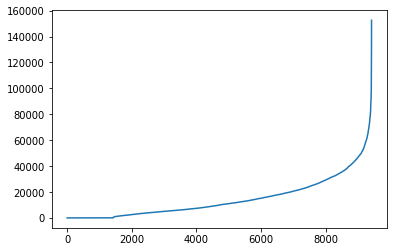

In [10]:

print(word_count / word_count.sum())
plt.plot([i for i in range(len(word_count))], sorted(word_count))

In [11]:
BATCH_SIZE = 128
SKIP_WINDOW = 12  # the context window

batch_gen = process_data(all_codones_f, dictionary, BATCH_SIZE, SKIP_WINDOW)

In [12]:
######################

In [13]:
class SkipGramModel(nn.Module):
    """ Build the graph for word2vec model """

    def __init__(self, vocab_size, embed_size):
        super(SkipGramModel, self).__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.v_embeddings = nn.Embedding(vocab_size, embed_size)
        self.u_embeddings = nn.Embedding(vocab_size, embed_size).cuda()
        init_range = 0.5 / (embed_size ** 0.5)
        self.v_embeddings.weight.data.uniform_(-init_range, init_range)
        self.u_embeddings.weight.data.uniform_(-0, 0)
        
        self.v_embeddings = self.v_embeddings.cuda()
        self.u_embeddings = self.u_embeddings.cuda()
        
    def forward(self, center, positive, negative):
        v_center = self.v_embeddings(torch.autograd.Variable(center))
        u_pos = self.u_embeddings(torch.autograd.Variable(positive))
        u_neg = self.u_embeddings(torch.autograd.Variable(negative))
        
        pos_loss = F.logsigmoid(
            torch.mul(u_pos, v_center).sum(dim=1)
        ).mean()
        
        neg_loss = F.logsigmoid(
            -1 * torch.bmm(u_neg, v_center.unsqueeze(2)).squeeze().sum(dim=1)
        ).mean()
        return -(pos_loss + neg_loss)
    
    def get_embeddings(self):
        return self.v_embeddings.weight.clone().detach().cpu().numpy()

In [20]:
VOCAB_SIZE = 9424
EMBED_SIZE = 100  # dimension of the word embedding vectors
NUM_SAMPLED = 5  # Number of negative examples to sample.
LEARNING_RATE = .5
NUM_TRAIN_STEPS = 400000
SKIP_STEP = 2000

print('cuda' if torch.cuda.is_available() else 'cpu')

cuda


In [15]:
######################

In [16]:
def make_dir(path):
    """ Create a directory if there isn't one already. """
    try:
        os.mkdir(path)
    except OSError:
        pass

In [17]:
def train_model(model, batch_gen, num_train_steps, optimizer, skip_step, neg_sampler, use_cuda=False):
    make_dir('checkpoints')
    total_loss = 0.0  # we use this to calculate late average loss in the last SKIP_STEP steps
    for index in range(1, 1 + num_train_steps):
        center, target = next(batch_gen)
        center, target = torch.LongTensor(center), torch.LongTensor(target)
        batch_size = len(center)
        neg_samples = neg_sampler.sample(batch_size)
        
        optimizer.zero_grad()
        if use_cuda:
            center, target, neg_samples = center.cuda(), target.cuda(), neg_samples.cuda()
            
        loss = model.forward(center, target, neg_samples)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss
        if (index + 1) % skip_step == 0:
            print('Average loss at step {}: {:5.1f}'.format(index, total_loss / skip_step))
            total_loss = 0.0
    return model.get_embeddings()

In [22]:
use_cuda = torch.cuda.is_available()
model = SkipGramModel(VOCAB_SIZE, EMBED_SIZE)
if use_cuda:
    model = model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
neg_sampler = WordSampler(word_count, NUM_SAMPLED)

In [23]:
embed_matrix = train_model(model, batch_gen, NUM_TRAIN_STEPS, optimizer, SKIP_STEP, neg_sampler, use_cuda)

Average loss at step 1999:   1.4
Average loss at step 3999:   1.4
Average loss at step 5999:   1.4
Average loss at step 7999:   1.4
Average loss at step 9999:   1.4
Average loss at step 11999:   1.4
Average loss at step 13999:   1.3
Average loss at step 15999:   1.4
Average loss at step 17999:   1.3
Average loss at step 19999:   1.0
Average loss at step 21999:   0.8
Average loss at step 23999:   0.7
Average loss at step 25999:   1.2
Average loss at step 27999:   1.2
Average loss at step 29999:   1.2
Average loss at step 31999:   1.2
Average loss at step 33999:   1.1
Average loss at step 35999:   1.1
Average loss at step 37999:   1.1
Average loss at step 39999:   1.1
Average loss at step 41999:   1.1
Average loss at step 43999:   1.1
Average loss at step 45999:   1.1
Average loss at step 47999:   1.1
Average loss at step 49999:   1.1
Average loss at step 51999:   1.1
Average loss at step 53999:   1.0
Average loss at step 55999:   1.1
Average loss at step 57999:   1.1
Average loss at ste

In [ ]:
######################

In [24]:
# embed_matrix = model.v_embeddings.weight.clone().detach().cpu().numpy()
tsne = TSNE(n_components=2, random_state=42)
print(embed_matrix)
XX = tsne.fit_transform(embed_matrix)

[[ 0.04269447 -0.05056071 -0.02167631 ...  0.07898047 -0.04379995
  -0.1149657 ]
 [ 0.09839846 -0.04735785 -0.114277   ...  0.07562938 -0.08996215
  -0.09534805]
 [ 0.01100641 -0.0791346  -0.00083285 ...  0.11928718 -0.07905386
  -0.12628795]
 ...
 [ 0.14082852 -0.05373317 -0.1437845  ...  0.00109229 -0.06792518
  -0.01237039]
 [ 0.11712255 -0.07364793 -0.07205294 ...  0.06870091 -0.11997896
  -0.11402102]
 [ 0.07058062 -0.08792605 -0.06236371 ...  0.06961113 -0.09181935
  -0.04861803]]


In [25]:
tsne_df = pd.DataFrame(XX, columns=['x0', 'x1'])
unique_codones = sorted(dictionary, key=dictionary.get)
tsne_df['codone'] = list(unique_codones)
tsne_df.head()

x0         x1 codone
0 -25.246826  -1.956245    PMK
1 -18.889277 -24.087774    PQA
2   3.440356  25.623741    NKT
3  -9.457192   7.728484    ARQ
4 -22.164249 -30.644978    LML

In [26]:
def plot_tsne_df(df):
    plt.figure(figsize=(15, 10))
    plt.title('unlabeled encoding', fontsize=20)
    plt.scatter(df.x0, df.x1, s=10)
    plt.show()

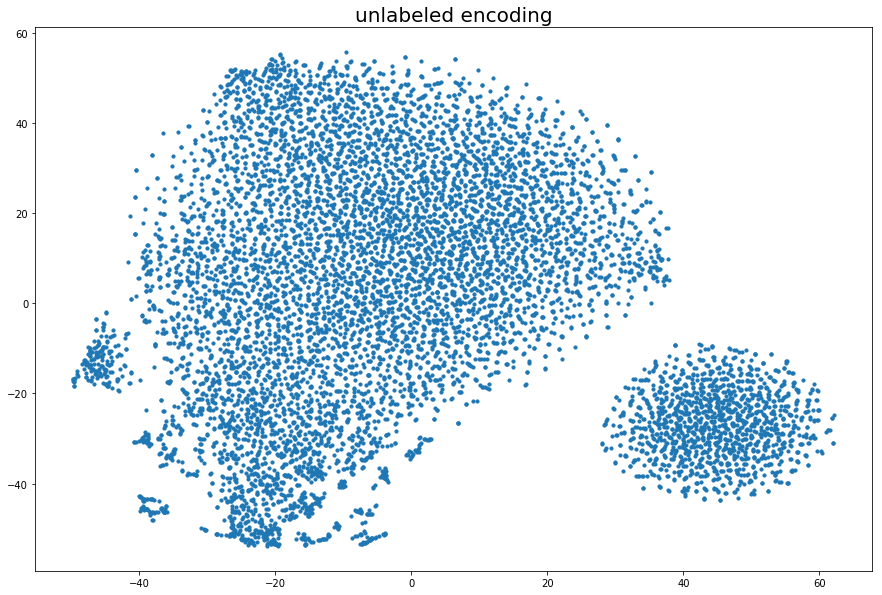

In [27]:
plot_tsne_df(tsne_df)

In [28]:
filename = 'data/acid_properties.csv'
props = pd.read_csv(filename)

In [29]:
######################

In [30]:
def acid_dict(some_c, props):
    prop_by_letter = [props[props.acid == let].iloc[:, 1:] for let in some_c]   
    df_concat = pd.concat(prop_by_letter)
    res = df_concat.mean()
    dres = dict(res)
    dres['acid'] = some_c
    return dres

In [31]:
def read_or_create(read_path, producer):
    if os.path.isfile(read_path):
        print('reading', read_path)
        with open(read_path, 'rb') as fp:
            return pickle.load(fp)
    result = producer()
    print('saving', read_path)
    with open(read_path, 'wb') as fp:
        pickle.dump(result, fp)
    return result

In [32]:
save_path = 'data/all_acid_dicts.pickle'
producer = lambda: [acid_dict(some_c, props) for some_c in tsne_df.codone]
all_acid_dicts = read_or_create(save_path, producer)

reading data/all_acid_dicts.pickle


In [33]:
all_acid_df = pd.DataFrame(all_acid_dicts)
all_acid_df.head()

acid  hydrophobicity        mass  number_of_atoms      volume
0  SPY       -1.233333  115.788600        18.333333  131.766667
1  XLP        1.100000  105.136400        19.500000  139.700000
2  IVK        1.600000  113.487000        21.666667  158.433333
3  MWH       -0.733333  151.515100        22.333333  181.300000
4  FMD        0.400000  131.152467        19.666667  154.633333

In [34]:
final_df = all_acid_df.join(tsne_df.set_index('codone'), on='acid')
final_df.head()

acid  hydrophobicity        mass  number_of_atoms      volume         x0  \
0  SPY       -1.233333  115.788600        18.333333  131.766667 -13.877064   
1  XLP        1.100000  105.136400        19.500000  139.700000  58.476017   
2  IVK        1.600000  113.487000        21.666667  158.433333 -24.289858   
3  MWH       -0.733333  151.515100        22.333333  181.300000  35.608044   
4  FMD        0.400000  131.152467        19.666667  154.633333  17.057489   

          x1  
0  23.402266  
1 -31.099306  
2  32.666847  
3   6.229737  
4  33.438877

In [35]:
def plot_embedding_properties(final_df):
    plt.figure(figsize=(25, 20))
    for i, p in enumerate(['hydrophobicity', 'mass', 'number_of_atoms', 'volume']):
        plt.subplot(2,2,i+1)
        plt.title(p, fontsize=25)
        plt.scatter(final_df.x0, final_df.x1, c=final_df[p], s=10)
    plt.show()

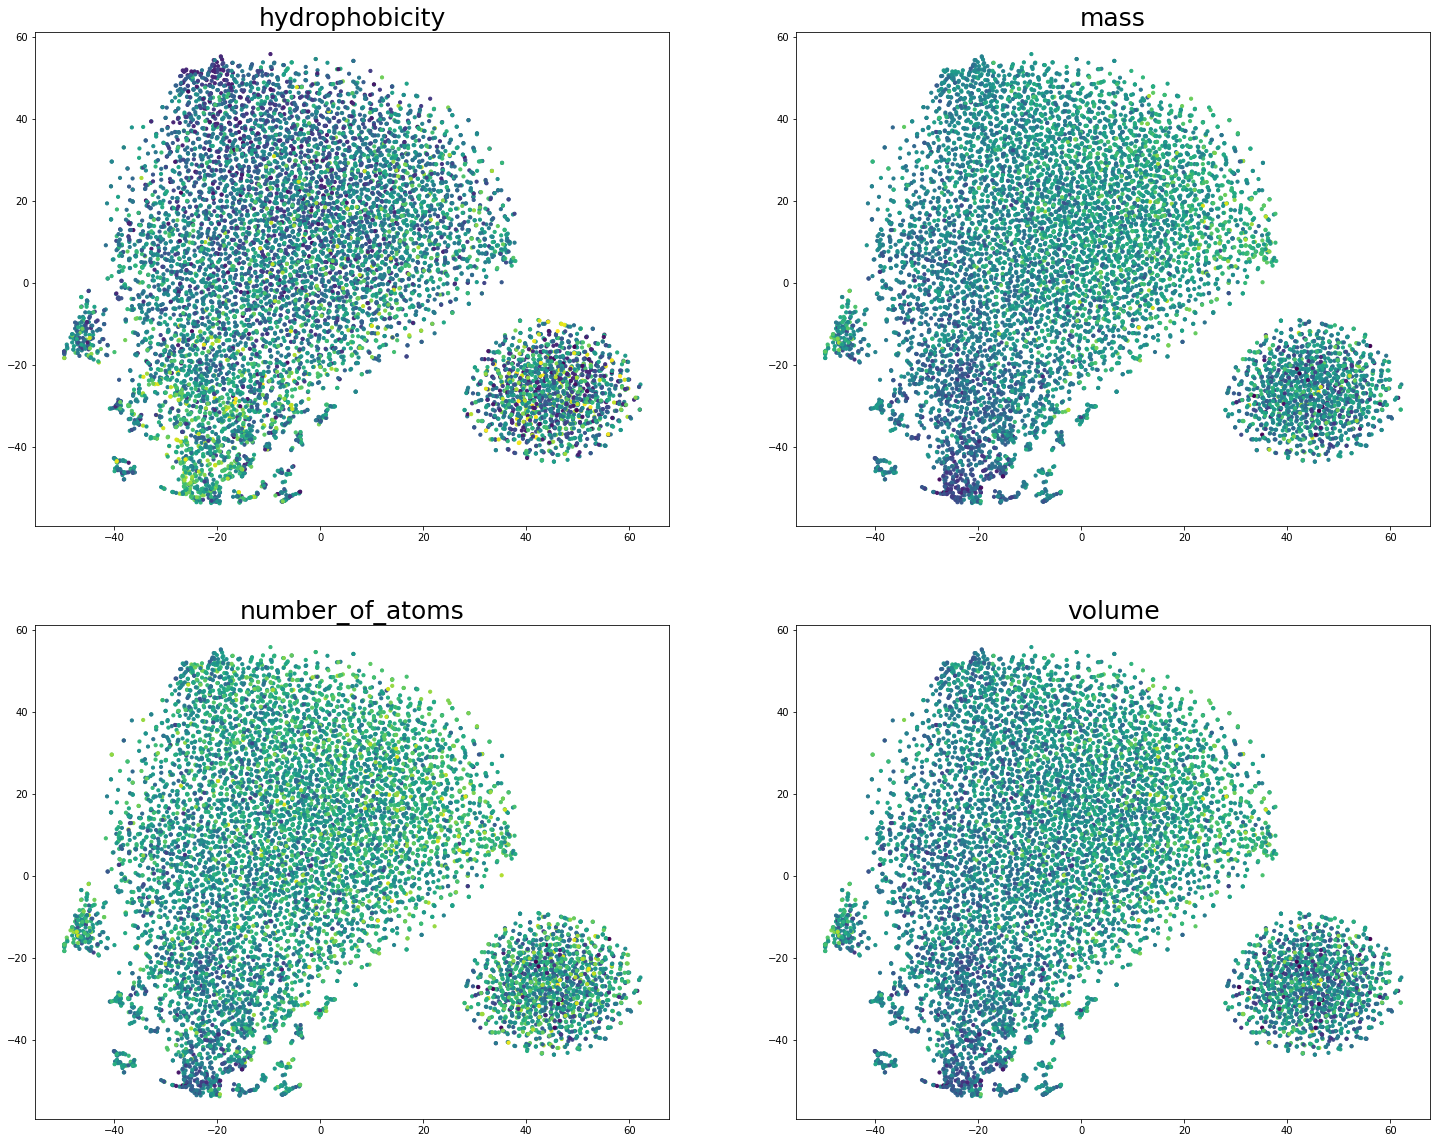

In [36]:
plot_embedding_properties(final_df)

In [36]:
summaryWriter = tensorboardX.SummaryWriter()
summaryWriter.add_embedding(embed_matrix)
summaryWriter.close()

In [37]:
######################

In [38]:
filename = 'data/nice_embed_tsne.csv'
gensim_tsne_df = pd.read_csv(filename, index_col=0)
gensim_tsne_df.columns = ['x0', 'x1', 'codone']

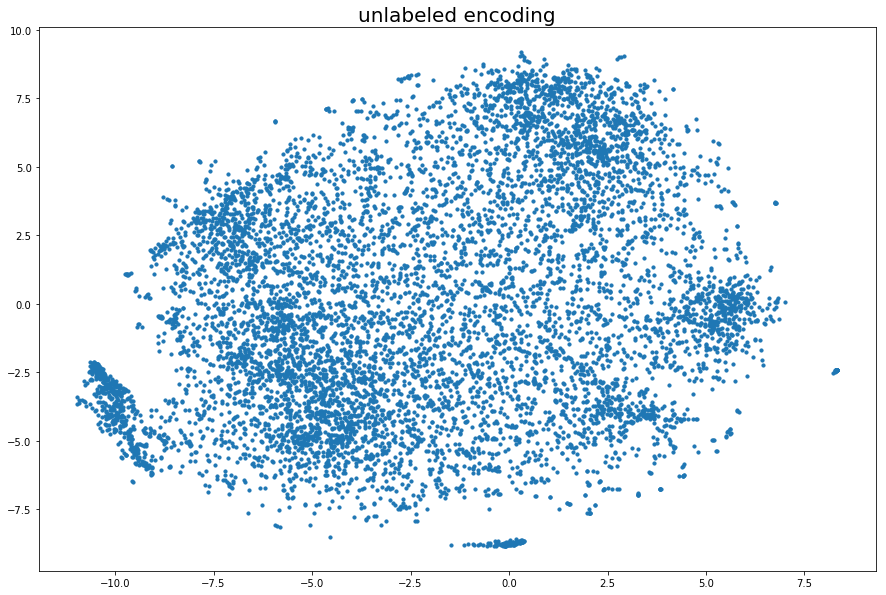

In [39]:
plot_tsne_df(gensim_tsne_df)

In [40]:
final_df_nice = all_acid_df.join(gensim_tsne_df.set_index('codone'), on='acid')

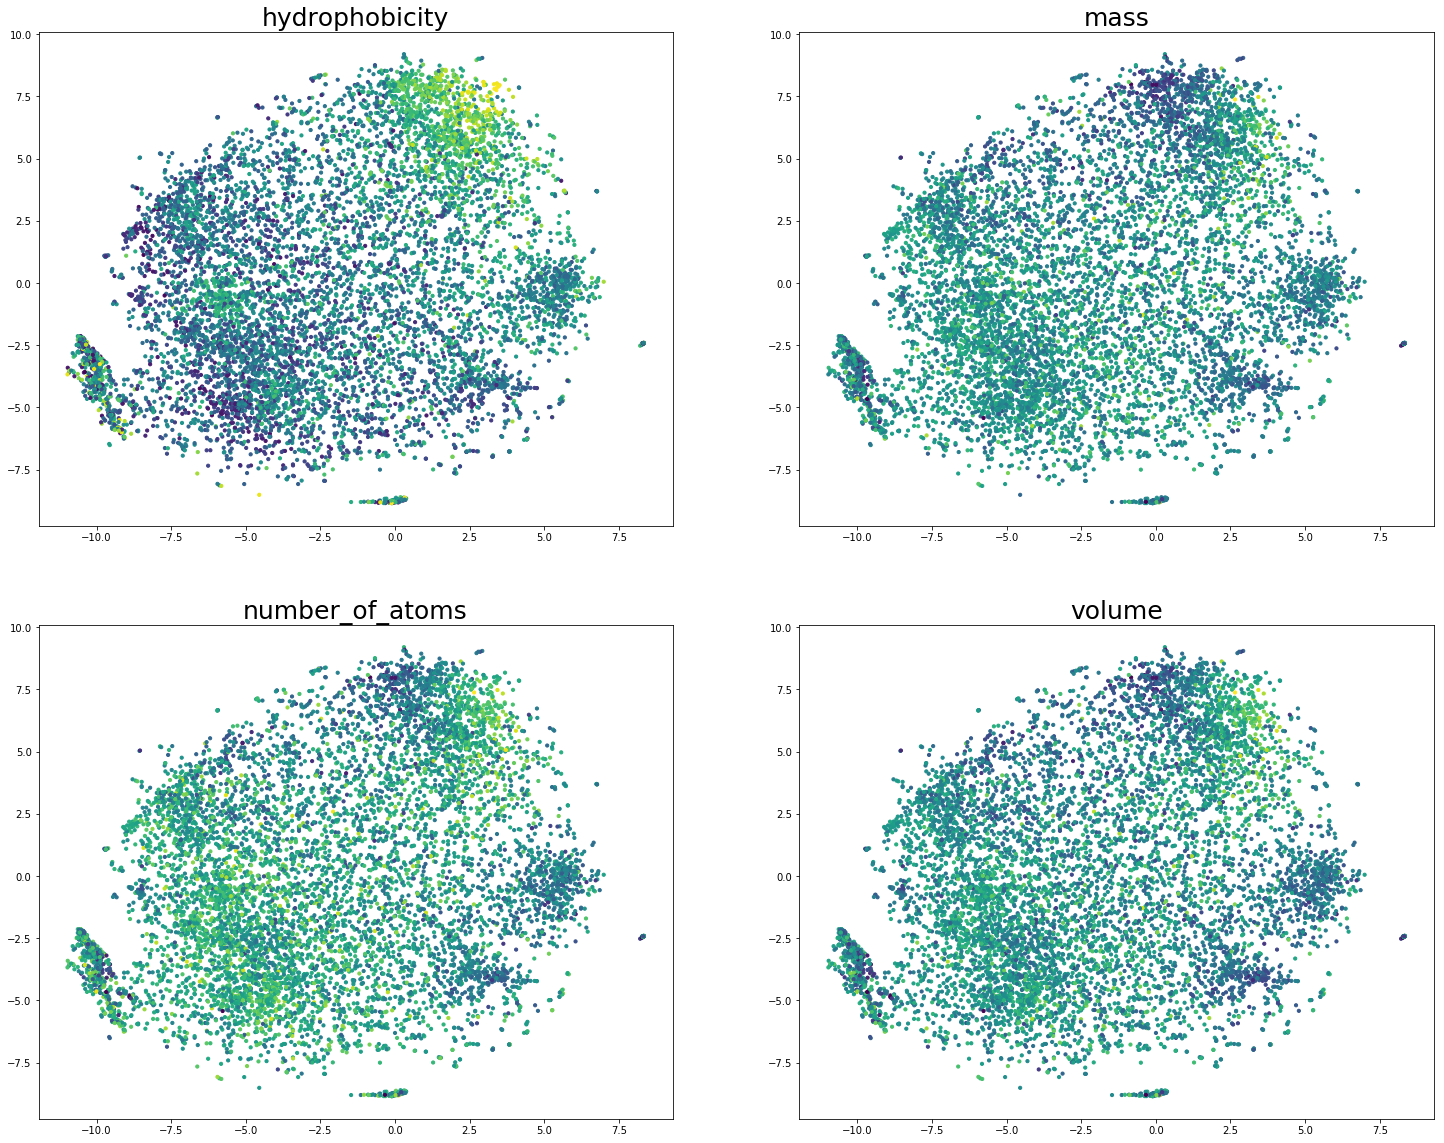

In [41]:
plot_embedding_properties(final_df_nice)

## Homework

* Implement in Pytorch and fine-tune this SkipGramModel to archive better embedding for amino acids codones. 
* Visualize your space in the similar style as on the bottom example. 
* Visualize 3D T-SNE in TensorboardX

Article with the original research can be found here http://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0141287&type=printable

Bonus task(no credit): visualize your embedding space in similar manner as minst example: https://www.tensorflow.org/versions/r0.12/how_tos/embedding_viz/

In [25]:
soft deadline: 14.10.2018 at 23.59

hard deadline: 17.01.2018 at 23.59

SyntaxError: invalid syntax (<ipython-input-25-fdda3a90776c>, line 1)